In [25]:
from pref_extract import find_restaurants, extract_all_preferences, extract_preference
import pandas as pd

21676
1297
Rate is:  0.8339869281045752


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\karst\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Epoch 1/12
339/339 [==============================] - 2s 5ms/step - loss: 0.5050 - accuracy: 0.9052 - val_loss: 1.2885 - val_accuracy: 0.8050
Epoch 2/12
339/339 [==============================] - 1s 3ms/step - loss: 0.1114 - accuracy: 0.9683 - val_loss: 1.6276 - val_accuracy: 0.8065
Epoch 3/12
339/339 [==============================] - 1s 3ms/step - loss: 0.0756 - accuracy: 0.9802 - val_loss: 1.7818 - val_accuracy: 0.8060
Epoch 4/12
339/339 [==============================] - 1s 3ms/step - loss: 0.0597 - accuracy: 0.9850 - val_loss: 1.9238 - val_accuracy: 0.8073
Epoch 5/12
339/339 [==============================] - 1s 3ms/step - loss: 0.0500 - accuracy: 0.9868 - val_loss: 2.0203 - val_accuracy: 0.8073
Epoch 6/12
339/339 [==============================] - 2s 5ms/step - loss: 0.0437 - accuracy: 0.9883 - val_loss: 2.1360 - val_accuracy: 0.8084
Epoch 7/12
339/339 [==============================] - 1s 4ms/step - loss: 0.0389 - accuracy: 0.9896 - val_loss: 2.1938 - val_accuracy: 0.8084
Epoch 

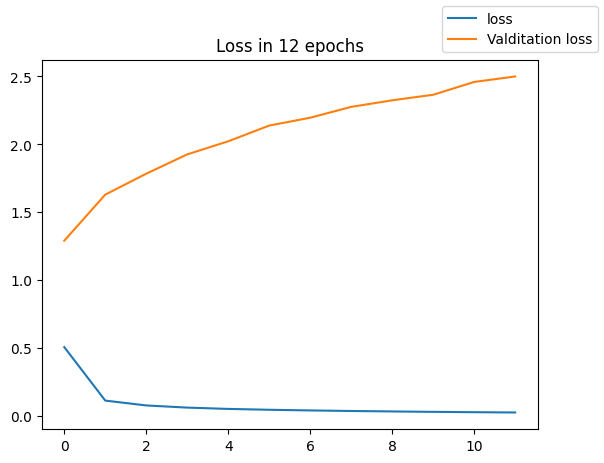

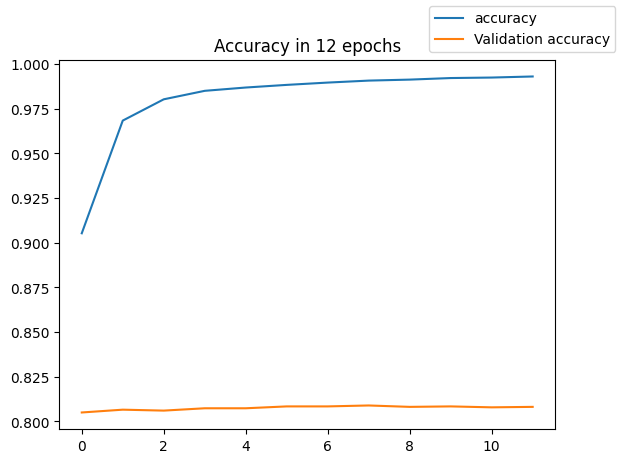

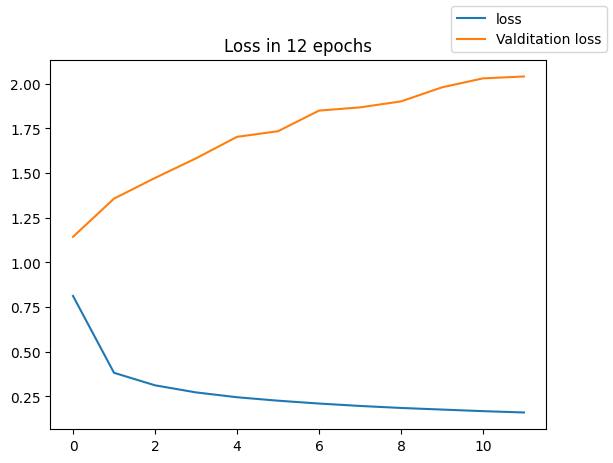

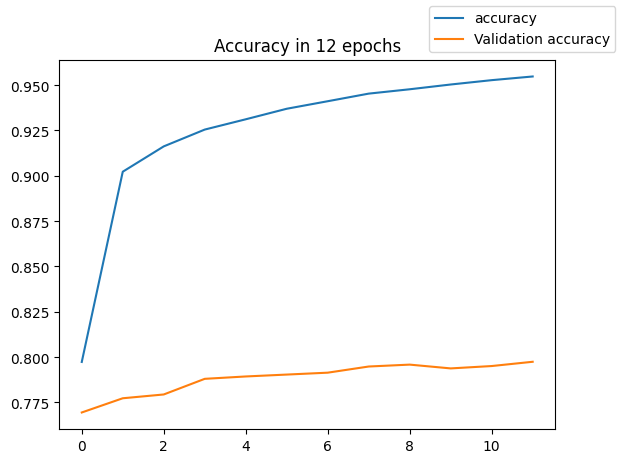

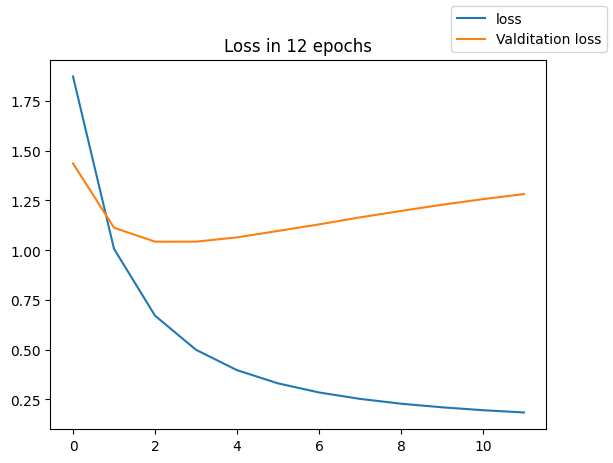

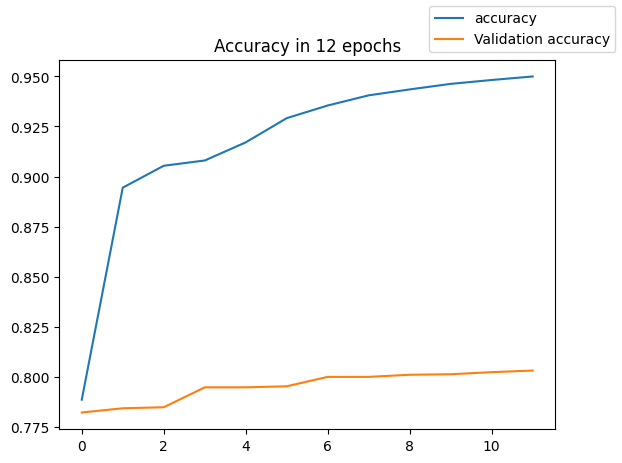

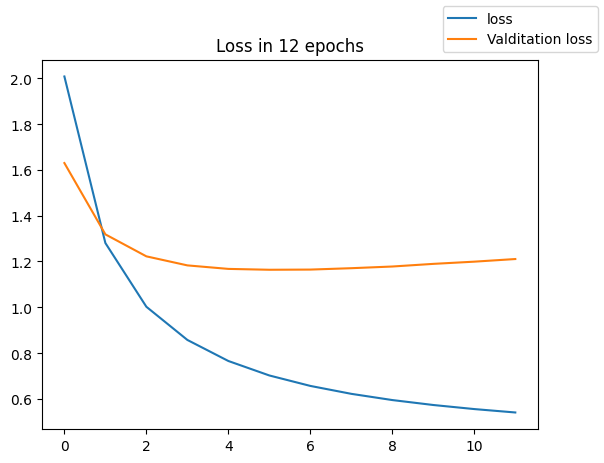

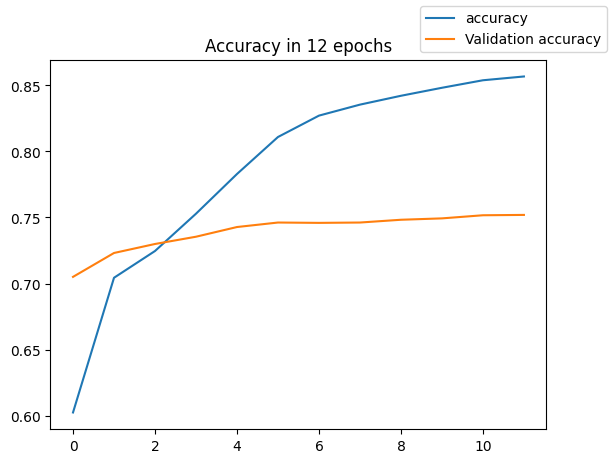

In [20]:
import importlib
import baseline
importlib.reload(baseline)
from baseline import prediction 

In [124]:
import regex as re
restaurant_info = pd.read_csv('restaurant_info.csv')

In [11]:
# Possible state transitions, not used, only to look at
# state_transition_possibilities = {
#     1: [2, 9],          
#     2: [2, 3, 9],
#     3: [3, 4, 9],
#     4: [4, 5, 9],
#     5: [6, 7, 9],
#     6: [5, 9],
#     7: [5, 8, 9],
#     8: [8, 9]
# }

In [138]:
class StateMachine:
    def __init__(self, restaurant_info):
        self.state = 1
        self.preferences = {
            'food_type': None,
            'area': None,
            'price': None
        }
        self.restaurant_info = restaurant_info
        self.restaurants_options = pd.DataFrame()
        self.restaurant_name = ""
        self.area = ""
        self.price = ""
        self.food_type = ""
        self.request_answer = ""
        self.requested_info = ""
        self.input_text = ""

        # TODO - add more messages
        self.message_dict = {
            1: "Welcome to FeastFinder, I will help find you a restaurant. Please tell what type of food would you like to eat, where, and in what price range",
            2: "In what area do you want to have dinner?",
            3: "What cuisine are you looking for?",
            4: "In what price range should the restaurant be?",
            5: 'Looking for a restaurant...',
            6: "I'm sorry, I don't see any restaurants matching your preferences in my database. Try providing different preferences.",
            7: f'{self.restaurant_name} is located in {self.area} and is a {self.price} {self.food_type}. Does it sounds good?',
            8: f'{self.requested_info} of {self.restaurant_name} is {self.request_answer}',
            9: "I hope you'll have a great time. Bye bye!",
            10: f"That is unfortunate. What do you think of {self.restaurant_name}",
            11: "That is not what I expected"
        }

        print(self.message_dict[self.state])
        utterance = input()
        self.change_state(utterance)
        

    def pattern_recog(self, utterance):
        match = re.search(r'\bany\b\s+(\w+)', utterance)
        print(match)
        if match:
            return match.group(1)
        else:
            return None
        
    def change_state(self, utterance = None):
        next_state, if_message = self.predict_next_state(utterance)
        if if_message:
            #print("current:", self.message_dict[self.state])
            print("next:", self.message_dict[next_state])
            utterance = input()
            self.state = next_state
            self.change_state(utterance)
        else:
            self.state = next_state
            self.change_state(utterance)
    
    def predict_next_state(self, utterance = None) -> tuple[int, bool]:
        """
        If the state should send a message, and then wait for user answer,
        it returns 'True'. If not, eg. state 2->4, returns False.
        :param utterance: 
        :return: tuple(next state number, if message sent) 
        """
        category = ""
        if utterance != None:
            category = prediction([utterance])
        #category = 'hello'
        if category == 'thankyou':
            return 9, True
        
        if self.state == 1:
            if utterance != None:
                self.preferences = extract_all_preferences(utterance)
            return 2, False
        
        if self.state == 2:
            if self.preferences['area'] is None:
                self.preferences.update(extract_all_preferences(utterance))
                word_after_any=self.pattern_recog(utterance)
                if word_after_any:
                    if extract_preference(word_after_any, ["area", "location", "part", "zone","sector","district"], 2):
                        self.preferences.update({"area": "any"})
            if self.preferences['area'] is None:
                # Even though the system only asks the area, the user can still specify also the price and/or food type
                return 2, True
            else:
                return 3, False
            
        if self.state == 3:
            if self.preferences['food_type'] is None:
                self.preferences.update(extract_all_preferences(utterance))
                word_after_any=self.pattern_recog(utterance)
                if word_after_any:
                    if extract_preference(word_after_any, ["food", "type", "kitchen", "food type","cuisine","taste"], 2):
                        self.preferences.update({"food_type": "any"})
            if self.preferences['food_type'] is None:
                return 3, True
            else:
                return 4, False
            
        if self.state == 4:
            if self.preferences['price'] is None:
                self.preferences.update(extract_all_preferences(utterance))
                word_after_any=self.pattern_recog(utterance)
                if word_after_any:
                    if extract_preference(word_after_any, ["price", "costs", "luxury", "amount","costs"], 2):
                        self.preferences.update({"price": "any"})
            if self.preferences['price'] is None:
                return 4, True
            else:
                return 5, False
        
        if self.state == 5:
            print("pref:",self.preferences)
            self.restaurants_options = find_restaurants(restaurant_info, self.preferences)
            if (self.restaurants_options.empty):
                return 6, True
            else:
                self.get_restaurant()
                message = f'{self.restaurant_name} is located in {self.area} and is a {self.price} {self.food_type}. Does it sound good?'
                self.message_dict[7] = message 
                return 7, True
        
        if self.state == 6:
            self.preferences.update(extract_all_preferences(utterance))
            self.restaurants_options = find_restaurants(self.restaurant_info, self.preferences)
            return 5, False
            
        if self.state == 7:
            # TODO - category prediction, now - hardcoded category
            # category = predict(utterance)
            # category = 'request' / 'reqalts'
            if category == 'request':
                return 8, True
            if category == 'regalts':
                return 5, False
            if category == "affirm":
                return 9, False
            if category == "negate":
                return 10, False
            else:
                return 11, False
            # TODO: what happens else?
            #return ???
            
        if self.state == 8:
            message = ""
            request_dict = {
                'food type': ["type", "food"],
                'phone number': ["phone", "number"],
                'adress': ["adress", "location"],
                'postalcode': ["postal", "postcode"]
             }
            for key, item in request_dict.items():
                if extract_preference(utterance, item, 2) != None:
                    message.append(f"The {key}, of {self.restaurant_name} is {self.request_answer} \n")
            
            self.message_dict[8] = message
            return 8, True
        
        if self.state == 9:
            # TODO - its basically end of dialog
            return 9, True
        if self.state == 10:
            if self.restaurants_options.empty:
                return 6, True
            self.get_restaurant()
            message1 = f"That is unfortunate. Does {self.restaurant_name} sound good?"
            print(message1)
            self.message_dict[7] = message1
            return 7, True

    def get_restaurant(self):
        rest = self.restaurants_options.sample()
        self.restaurant_name =rest["restaurantname"].values[0]
        self.area = rest["area"].values[0]
        self.price = rest["pricerange"].values[0]
        self.food_type = rest["food"].values[0]
        self.restaurants_options = self.restaurants_options.drop(rest.index)
           
SM = StateMachine(restaurant_info)



Welcome to FeastFinder, I will help find you a restaurant. Please tell what type of food would you like to eat, where, and in what price range
1/1 [==============================] - 0s 18ms/step
<regex.Match object; span=(15, 27), match='any location'>
1/1 [==============================] - 0s 18ms/step
pref: {'food_type': 'thai', 'area': 'any', 'price': 'expensive'}
   restaurantname pricerange    area  food         phone  \
23   bangkok city  expensive  centre  thai  01223 354382   
40     sala thong  expensive    west  thai  01223 323178   

                           addr postcode  
23  24 green street city centre    c.b 2  
40      35 newnham road newnham    c.b 3  
next: hk fusion is located in centre and is a expensive thai. Does it sound good?
1/1 [==============================] - 0s 19ms/step
   restaurantname pricerange  area  food         phone  \
40     sala thong  expensive  west  thai  01223 323178   

                       addr postcode  
40  35 newnham road newnham   